In [ ]:
# installing dependencies
!pip install -q accelerate transformers safetensors bitsandbytes datasets peft torchaudio gradio torchvision --quiet
!pip install git+https://github.com/huggingface/diffusers

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-mt9v6rz8
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-mt9v6rz8
  Resolved https://github.com/huggingface/diffusers to commit b975bceff3558b7d93566e18f47f20862cb6b977
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Importing dependencies
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPTokenizer, CLIPTextModel, CLIPFeatureExtractor
import torch
from torch.optim import AdamW
from tqdm import tqdm
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
import json

In [ ]:
# Parse Captions and Prepare Dataset
# Define paths
image_dir = "/content/drive/MyDrive/Colab_Notebooks/multimodal_data/images"
caption_path = "/content/drive/MyDrive/Colab_Notebooks/multimodal_data/captions.txt"

# Read the CSV-like caption file
df = pd.read_csv(caption_path, header=0, names=["image", "caption"])

# Optional: Reduce to a smaller subset for Colab limits
df = df.sample(n=min(len(df), 500), random_state=42)

# (Optional) Remove whitespace from image paths if needed
df['image'] = df['image'].str.strip()

In [ ]:
# Dataset Class
class FlickrDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(os.path.join(self.image_dir, row['image'])).convert('RGB')
        encoding = self.processor(images=image, text=row['caption'], padding="max_length", return_tensors="pt", max_length=32, truncation=True)
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding['labels'] = encoding['input_ids']
        return encoding

In [ ]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

dataset = FlickrDataset(df, image_dir, processor)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(1):
    loop = tqdm(loader, leave=True)
    for batch in loop:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=8.52]


In [ ]:
# Inference: Image → Caption
model.eval()
sample_image_path = os.path.join(image_dir, df.iloc[0]['image'])
image = Image.open(sample_image_path).convert('RGB')
inputs = processor(images=image, return_tensors="pt").to(device)
out = model.generate(**inputs)
print("Prediction:", processor.decode(out[0], skip_special_tokens=True))

Prediction: a group of young men standing in front of a sign


In [ ]:
# dependencies import and installation
%cd /content/drive/MyDrive/Colab_Notebooks/
# !git clone https://github.com/huggingface/diffusers
%cd diffusers
# !pip install -e .

/content/drive/MyDrive/Colab_Notebooks
/content/drive/MyDrive/Colab_Notebooks/diffusers


In [ ]:
# Create the metadata.jsonl file
excel_file = '/content/drive/MyDrive/Colab_Notebooks/multimodal_data/captions.xlsx'
images_dir = '/content/drive/MyDrive/Colab_Notebooks/multimodal_data/images'
output_jsonl = os.path.join(images_dir, 'metadata.jsonl')

# Load Excel file
df = pd.read_excel(excel_file)

# Ensure column names are correct
assert 'image' in df.columns and 'caption' in df.columns, "Excel must have 'image' and 'caption' columns."

# Write JSONL file
with open(output_jsonl, 'w') as jsonlfile:
    for _, row in df.iterrows():
        file_name = os.path.basename(row['image'])
        caption = str(row['caption']).strip()
        json_line = {"file_name": file_name, "text": caption}
        jsonlfile.write(json.dumps(json_line) + '\n')

In [ ]:
import shutil

drive_path = "/content/drive/MyDrive/Colab_Notebooks/multimodal_data/images"
local_path = "/content/multimodal_train_data"

shutil.copytree(drive_path, local_path, dirs_exist_ok=True)

'/content/multimodal_train_data'

In [ ]:
# Dataset retrieve
df = pd.read_json("/content/multimodal_train_data/metadata.jsonl", lines=True)
print(df.iloc[0])

file_name                                  20180404_110003.jpg
text         Some teenagers(probably friends) taking pose i...
Name: 0, dtype: object


In [ ]:
# Data modelling
class CustomImageTextDataset(Dataset):
    def __init__(self, jsonl_path, images_dir):
        self.images_dir = images_dir
        with open(jsonl_path, 'r') as f:
            self.data = [json.loads(line) for line in f]
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item["file_name"])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {"pixel_values": image, "text": item["text"]}


train_dataset = CustomImageTextDataset(
    jsonl_path="/content/multimodal_train_data/metadata.jsonl",
    images_dir="/content/multimodal_train_data/"
)

# Load pretrained components from Stable Diffusion
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="safety_checker")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-large-patch14")

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for batch in train_dataloader:
    inputs = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    ).input_ids
    pixel_values = batch["pixel_values"]

    # You can now use `inputs` and `pixel_values` for training/fine-tuning
    break  # remove this when training loop is implemented


# Rebuild the pipeline from your fine-tuned components
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=feature_extractor
).to(device)

pipeline.save_pretrained("/content/multimodal_train_data/sd-text2img")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

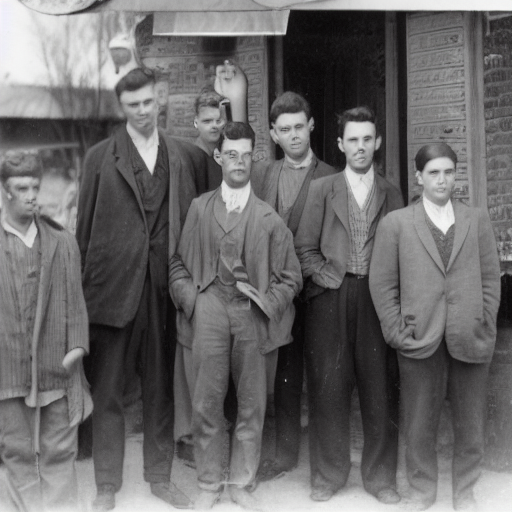

In [ ]:
# image generation from caption
pipe = StableDiffusionPipeline.from_pretrained(
    "/content/multimodal_train_data/sd-text2img",
    torch_dtype=torch.float16
).to("cuda")

prompt = "a group of young men standing in front of a sign"
image = pipe(prompt).images[0]
image.save("/content/multimodal_train_data/custom_generated.png")
display(image)